In [500]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')

In [501]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

<b>Data Cleaning

In [502]:
# Find null values.
df.isnull().sum().sort_values(ascending=False).head(20)

poolqc          1453
miscfeature     1406
alley           1369
fence           1179
fireplacequ      690
lotfrontage      259
garagecond        81
garagetype        81
garageyrblt       81
garagefinish      81
garagequal        81
bsmtexposure      38
bsmtfintype2      38
bsmtfintype1      37
bsmtcond          37
bsmtqual          37
masvnrarea         8
masvnrtype         8
electrical         1
utilities          0
dtype: int64

<b>Since we are not interested in using any of these variables(columns) in our model, let us drop all these.

In [503]:
df = df.dropna(axis=1)
df = df.drop(['id'],axis=1)

<b>Note:</b> Our target variable in this context is "saleprice".

There are many numerical variables like 'overallqual', 'yearbuilt' etc which are actually categoric variables. Hence, let us segregate these into categorical and numerical types as shown below.

In [504]:
# Finding categorical and continuous variables.
cat_list = list(df.describe(include=['O']).columns)
# Categorical columns which are actually numeric.
categorical_cols = ['mssubclass','overallqual','overallcond','yearbuilt','yearremodadd','bsmtfullbath','bsmthalfbath',
            'fullbath','halfbath','bedroomabvgr','kitchenabvgr','totrmsabvgrd','fireplaces',
            'garagecars','mosold','yrsold']
# Final list of categorical columns.
cat_cols = cat_list + categorical_cols


num_cols_dict = {'lotarea':1,'bsmtfinsf1':2,'bsmtfinsf2':3,'bsmtunfsf':4,
            'totalbsmtsf':5,'firstflrsf':6,'secondflrsf':7,'lowqualfinsf':8,'grlivarea':9,
           'garagearea':10,'wooddecksf':11,
            'openporchsf':12,'enclosedporch':13,'threessnporch':14,'screenporch':15,'poolarea':16,'miscval':17,
            'saleprice':18}
# Final list of numerical columns.
num_cols = list(num_cols_dict.keys())

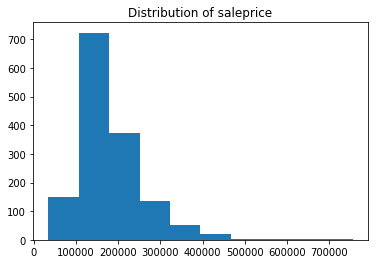

In [505]:
# Observe the distribution of the target variable.
plt.hist(df['saleprice'])
plt.title("Distribution of saleprice")
plt.show()

<b>Observation:</b> From the above, it is clear that our target variable(saleprice) is NOT normally distributed.

<b>Let us observe the correlation between continuous variables and our target variable(saleprice).

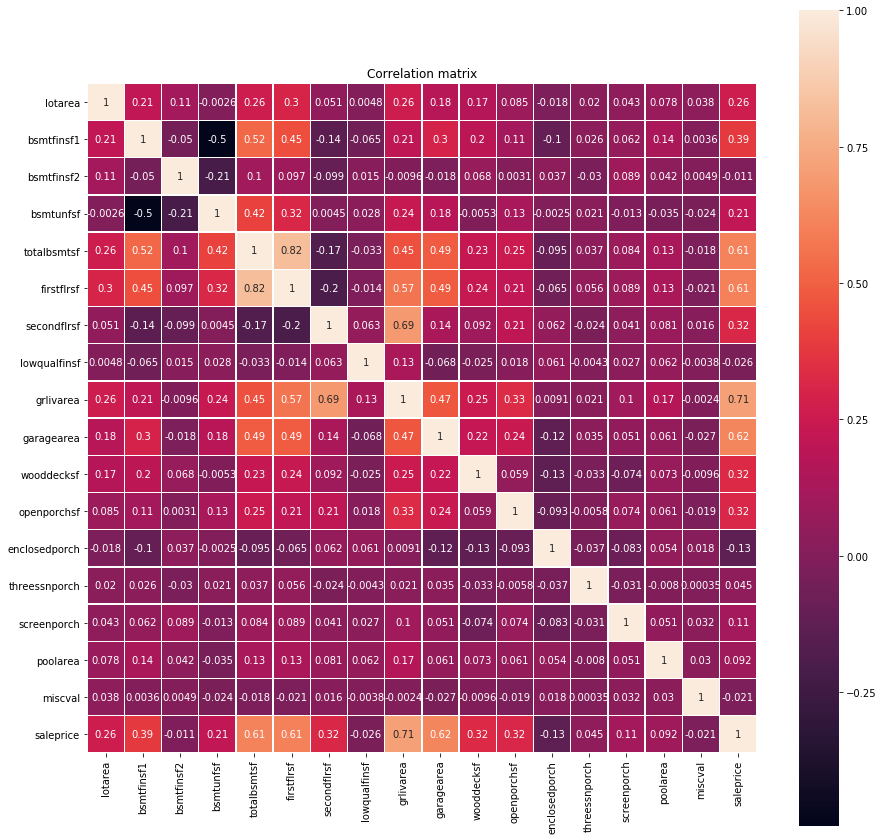

In [506]:
# Find correlation
num_df = df[num_cols]
cor_mat = num_df.corr()

# Plot correlation using heatmap.
plt.figure(figsize=(15,15))
sns.heatmap(cor_mat, square=True, annot=True, linewidths=.5)
plt.title("Correlation matrix")
plt.show()

In [507]:
# Observe the correlation values for saleprice.
cor_mat.loc['saleprice'].sort_values(ascending=False)

saleprice        1.000000
grlivarea        0.708624
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
bsmtfinsf1       0.386420
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
lotarea          0.263843
bsmtunfsf        0.214479
screenporch      0.111447
poolarea         0.092404
threessnporch    0.044584
bsmtfinsf2      -0.011378
miscval         -0.021190
lowqualfinsf    -0.025606
enclosedporch   -0.128578
Name: saleprice, dtype: float64

<b>From the above, the following 4 variables have better correlation with "saleprice". So, these 4 will be part of feature columns for our model.<br/>
grlivarea, garagearea, totalbsmtsf, firstflrsf</b>

Let us observe the relation between categorical variables and saleprice.

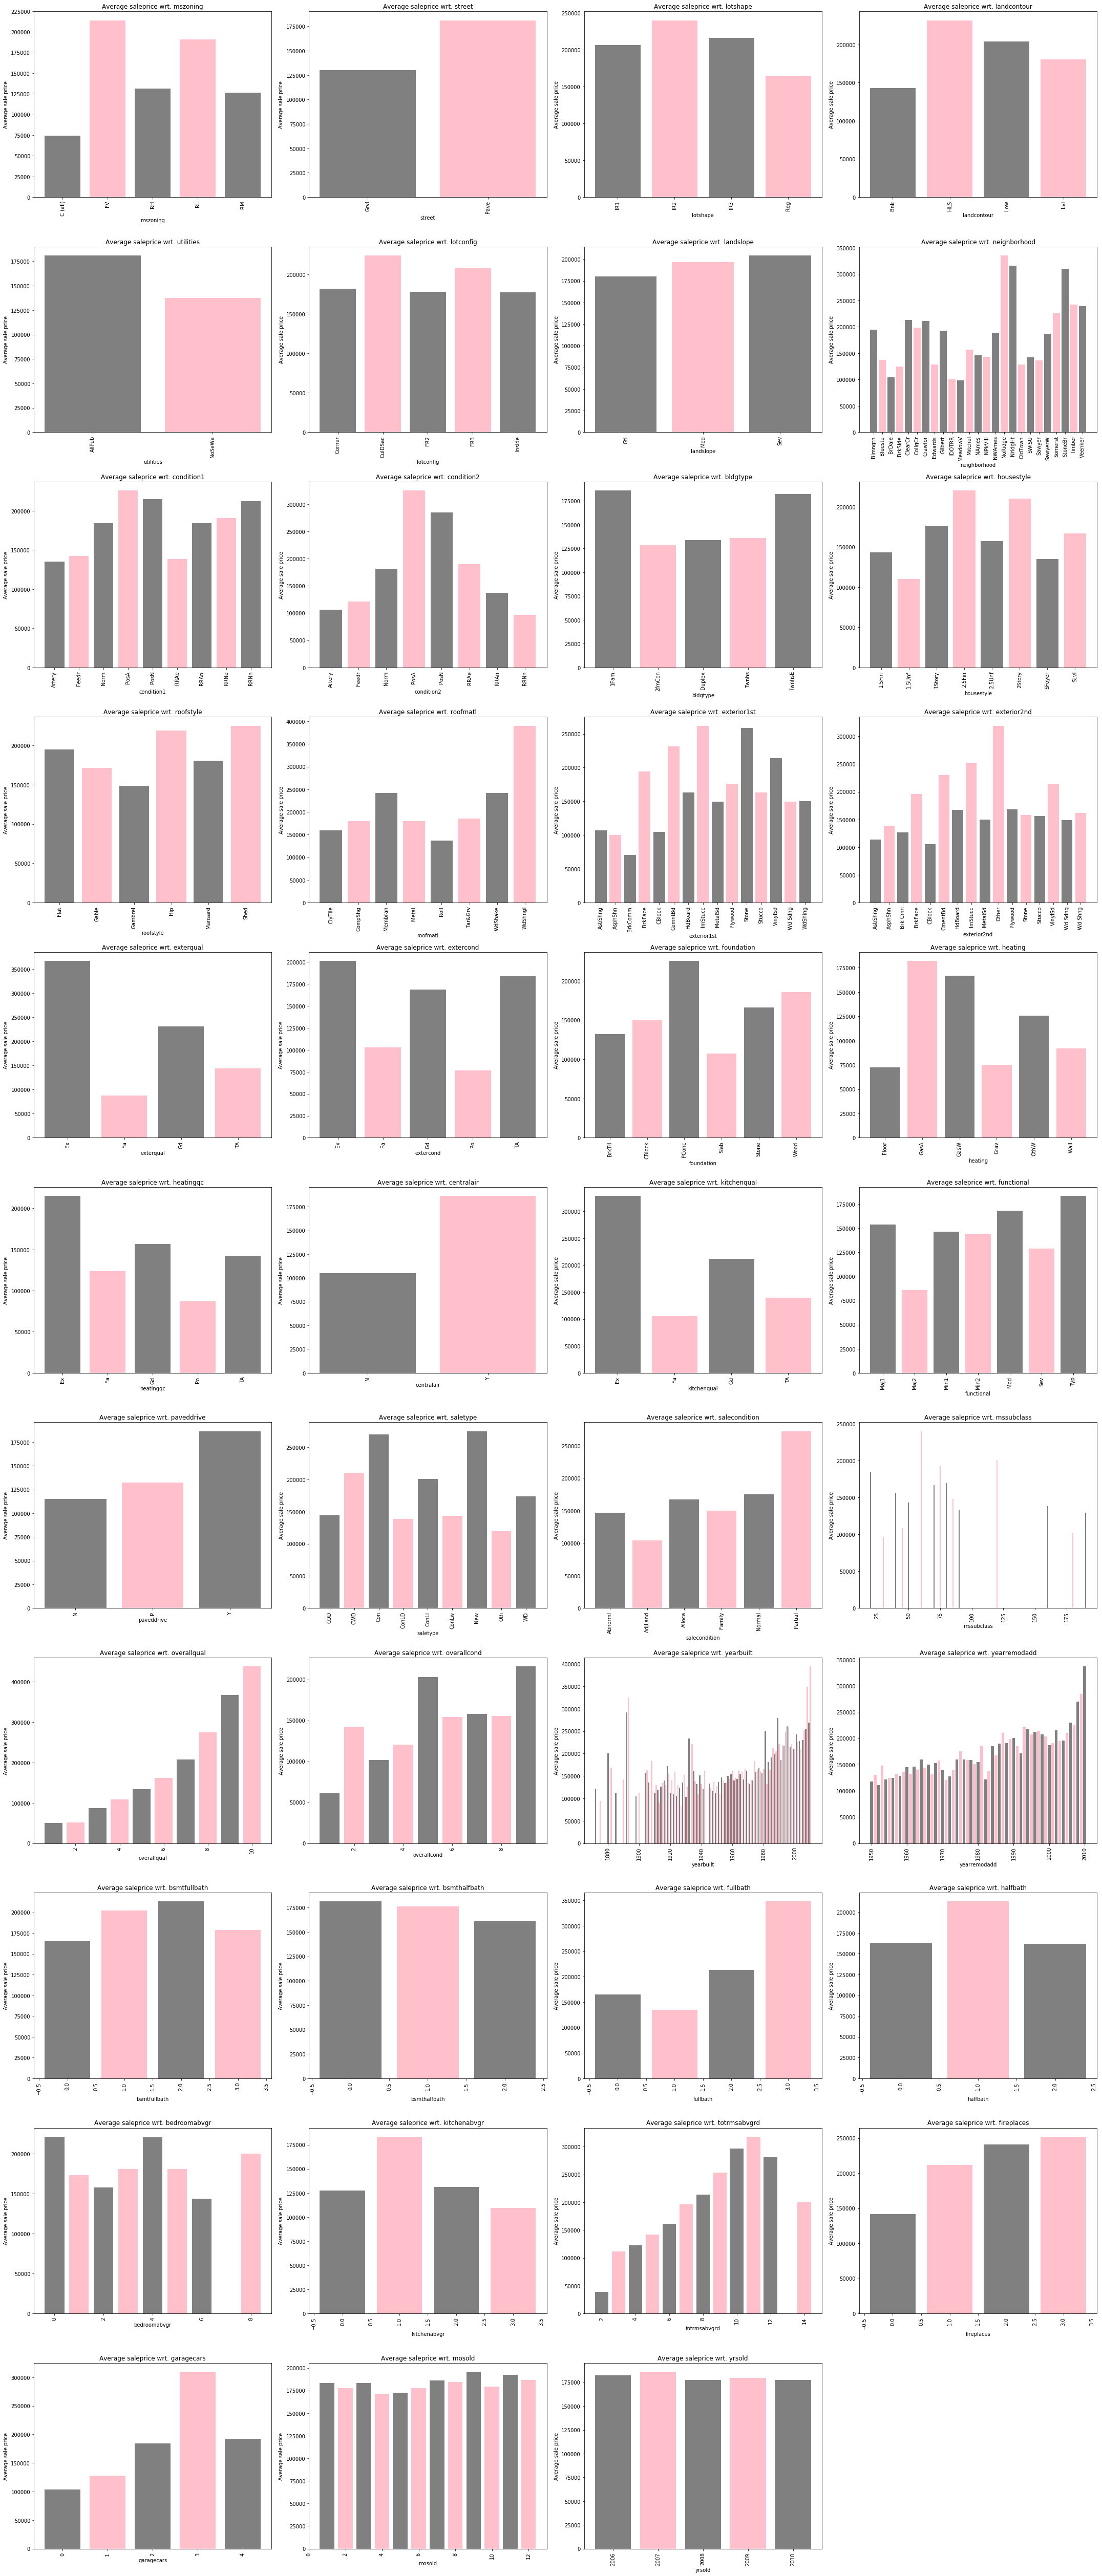

In [508]:
# Observe the relation between categorical variables and saleprice using bar plots.

plt.figure(figsize=(30,70))

for index, column in enumerate(cat_cols):
    plt.subplot(11,4,index+1)
    plt.bar(df.groupby(column)["saleprice"].mean().index, df.groupby(column)["saleprice"].mean(),
           color=("grey","pink"))
    plt.title("Average saleprice wrt. {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

From the above, let us pick the variables 'street' and 'overallqual' as they exhibit a linear relationship with our target variable(saleprice).<br/>
<b>Note:</b> We can pick many other variables too. As I'm targeting to build a model with minimum variables required, I picked only 2.<br/>
So, our final list of features contains below columns.<br/>
street, overallqual, grlivarea, garagearea, totalbsmtsf, firstflrsf

In [509]:
# Convert non-numerical features into dummy variables.
feature_df = df[['street','overallqual','grlivarea','garagearea','totalbsmtsf','firstflrsf']]
feature_df = pd.concat([feature_df,pd.get_dummies(final_df['street'],drop_first=True)],axis=1)
feature_df = feature_df.drop('street',axis=1)

In [510]:
feature_df.head()

,overallqual,grlivarea,garagearea,totalbsmtsf,firstflrsf,Pave
0,7,1710,548,856,856,1
1,6,1262,460,1262,1262,1
2,7,1786,608,920,920,1
3,7,1717,642,756,961,1
4,8,2198,836,1145,1145,1


<b>Method 1 : Regression Model using LinearRegression() from scikit-learn.

In [511]:
from sklearn import linear_model
# Let us build our regression model using LinearRegression().
# X is the feature set 
X = feature_df
# Y is the target variable
Y = df.saleprice

# We create a LinearRegression model object from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()
# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [2.52611517e+04 4.33267340e+01 5.70871617e+01 2.29772236e+01
 1.12855652e+01 1.10428852e+04]

Intercept: 
 -114230.90964685215


According to the estimation results, the constant term is -114230.91. The estimated coefficients of the features are 2.52611517e+04 4.33267340e+01 5.70871617e+01 2.29772236e+01
 1.12855652e+01 1.10428852e+04 respectively. 

<b>Method 2 : Regression Model using statsmodels.

In [512]:
# Let us build our regression model using statsmodels.
# X is the feature set 
X = feature_df
# Y is the target variable
Y = df.saleprice

X = sm.add_constant(X)
result = sm.OLS(Y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     759.4
Date:                Sat, 18 May 2019   Prob (F-statistic):               0.00
Time:                        15:11:18   Log-Likelihood:                -17508.
No. Observations:                1460   AIC:                         3.503e+04
Df Residuals:                    1453   BIC:                         3.507e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.142e+05   1.65e+04     -6.922      0.000   -1.47e+05   -8.19e+04
overallqual  2.526e+04   1059.349     23.846      0.000    2.32e+04    2.73e+04
grlivarea      43.3267      2.701     16.042      0.000      38.029      48.625
garagearea     57.0872      6.156      9.273      0.000      45.011      69.163
totalbsmtsf    22.9772      4.341      5.293      0.000      14.462      31.492
firstflrsf     11.2856      5.071      2.225      0.026       1.338      21.233
Pave         1.104e+04   1.61e+04      0.685      0.494   -2.06e+04    4.27e+04
==============================================================================
Omnibus:                      507.094   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            52743.498
Skew:                          -0.600   Prob(JB):                         0.00
Kurtosis:                      32.421   Cond. No.                     5.20e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""